In [1]:
DATA_PATH = '/home/kotuzo/DATA_NINJA_COMP/EPIK_Solution/all_data/extracted/transformed/'
SQ_DATA_PATH = '/home/kotuzo/DATA_NINJA_COMP/EPIK_Solution/all_data/extracted/search_queries/'
AD_DATA_PATH = '/home/kotuzo/DATA_NINJA_COMP/EPIK_Solution/all_data/extracted/ads/'

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
pd.set_option('display.max_columns', 50)

In [3]:
data = pd.read_csv(DATA_PATH + 'transformed2016_12.csv')

In [4]:
data.head()

,id,category_id,title,description,predict_sold,predict_replies,predict_views,priceValue,derivative,average,min,max,business,private,arranged,exchange,free,price,new,used,photo_sizes,paidads_id_index,paidads_valid_to
0,471113355,279,Ekogroszek workowany Pieklorz <CITY> - POLMARK...,"Ekogroszek Pieklorz chwałowicki - ""Iskierka zi...",f,0,19,940.0,63.437363,547.0,2.0,1787.0,1,0,0,0,0,1,1,0,"{""1"":{""w"":489,""h"":700}}",NaN,NaN
1,144496390,279,"KOMINEK MARKOWY, efekt żarzenia, ""<SURNAME> <N...","KOMINEK FIRMY ZEPTER ""<SURNAME> <NAME> Serce"" ...",f,0,13,950.0,63.437363,547.0,2.0,1787.0,0,1,1,0,0,0,1,0,"{""1"":{""w"":616,""h"":461},""2"":{""w"":616,""h"":461},""...",NaN,NaN
2,1499520116,279,Piec akumulacyjny dynamiczny 2-5 kw w zestawie...,PROMOCJA !!! do 30.10.16\nElektryczny ogrzewac...,f,0,16,1599.0,63.437363,547.0,2.0,1787.0,1,0,0,0,0,1,1,0,"{""6"":{""w"":640,""h"":480},""4"":{""w"":933,""h"":700},""...",4.0,2016-12-11 09:01:51
3,1771070936,279,Sprzedam węgiel,Sprzedam węgiel dobrej jakości .<CITY> i okoli...,f,1,53,630.0,63.437363,547.0,2.0,1787.0,1,0,0,0,0,1,1,0,"{""1"":{""w"":525,""h"":700}}",NaN,NaN
4,1903540578,279,Termostaty!!Oszczędzaj ciepło!,Oszczędzaj ciepło nawet 30%Sprzedam 6szt [cena...,f,0,11,22.0,63.437363,547.0,2.0,1787.0,0,1,1,0,0,0,1,0,"{""2"":{""w"":616,""h"":461},""1"":{""w"":616,""h"":461},""...",NaN,NaN


In [5]:
sq_data = pd.read_csv(SQ_DATA_PATH + 'search_queries_2016_12.csv')

In [6]:
data.columns

Index(['id', 'category_id', 'title', 'description', 'predict_sold',
       'predict_replies', 'predict_views', 'priceValue', 'derivative',
       'average', 'min', 'max', 'business', 'private', 'arranged', 'exchange',
       'free', 'price', 'new', 'used', 'photo_sizes', 'paidads_id_index',
       'paidads_valid_to'],
      dtype='object')

In [7]:
data['predict_sold'] = data['predict_sold'].apply(lambda x: 0 if x == 'f' else 1)

In [8]:
num_feat = ['category_id', 'priceValue', 'derivative',
           'average', 'min', 'max', 'business', 'private', 'arranged', 'exchange',
           'free', 'price', 'new', 'used', 'paidads_id_index', 'paidads_valid_to',
           'predict_sold', 'predict_views', 'predict_replies']

In [9]:
data['category_id'].nunique()

248

In [11]:
data[data['predict_sold'] == 1]['category_id'].value_counts().head(10)

230    7470
642    5216
231    4150
93     1966
224    1646
282    1488
575    1448
734    1434
235    1265
506    1040
Name: category_id, dtype: int64

In [12]:
data[data['predict_sold'] == 0]['category_id'].value_counts().head(10)

642     164489
230     161475
224      44714
231      40614
734      37075
575      31680
506      23008
235      17199
93       15092
1157     14323
Name: category_id, dtype: int64

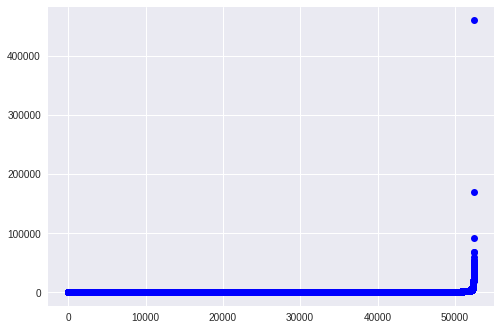

In [13]:
plt.plot(data[data['predict_sold'] == 1]['priceValue'].dropna().sort_values().values, 'bo')

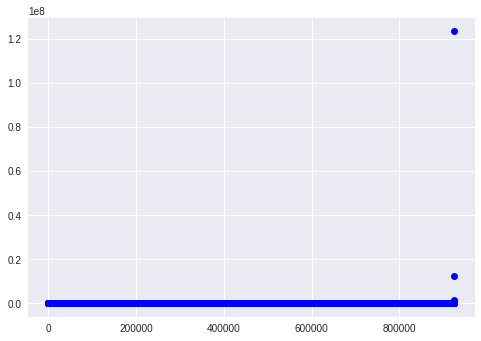

In [14]:
plt.plot(data[data['predict_sold'] == 0]['priceValue'].dropna().sort_values().values, 'bo')

In [113]:
corrmat = data[num_feat].corr()

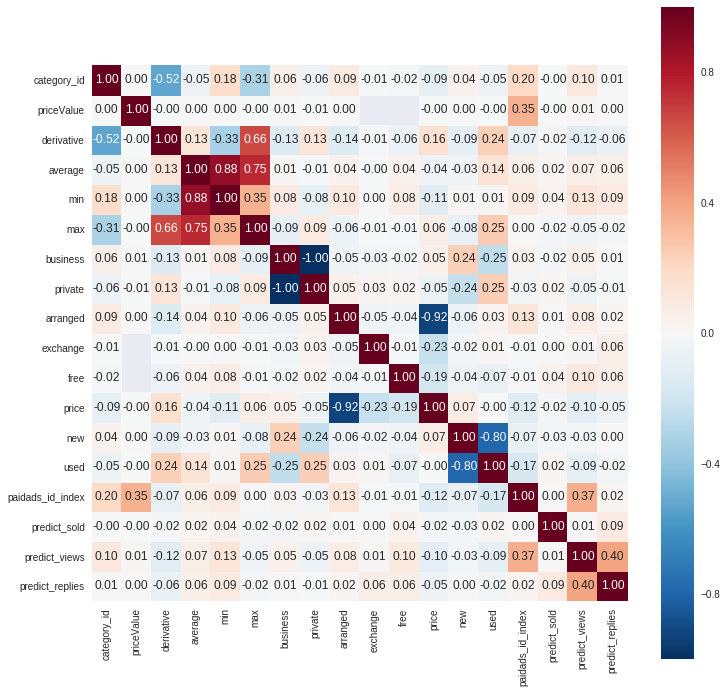

In [114]:
plt.figure(figsize=(12,12))
sns.heatmap(corrmat, square=True, annot=True, fmt='.2f')

In [17]:
sq_data.head()

,sorting_date,phrase,category_id,sessions_count,parent_id,name_pl
0,2016-11-21,NaN,15.0,85916.0,1307,Wynajem
1,2016-11-21,kawalerka,15.0,968.0,1307,Wynajem
2,2016-11-21,mieszkanie,15.0,183.0,1307,Wynajem
3,2016-11-21,warszawa,15.0,154.0,1307,Wynajem
4,2016-11-21,2 pokoje,15.0,150.0,1307,Wynajem


In [18]:
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation

Stop words

In [19]:
stop_words = []
with open('src/learn/polish_stopwords.txt', 'r') as f:
    stop_words = [line[:-1] for line in f]
numbers = ['0', '1', '2','3', '4', '5', '6', '7', '8' ,'9']
stop_words += numbers

In [33]:
def constraint(upper_bound):
    def decorator(func):
        def inner(sq_data, cat_id):
            temp_res = func(sq_data, cat_id)
            top_words = sorted(temp_res.items(), 
                               key=lambda x: x[1], 
                               reverse=True)[:upper_bound]
            return top_words
        return inner
    return decorator       

@constraint(3)
def get_words_and_counts(sq_data, cat_id):
    words = {}
    for _, row in sq_data[(sq_data['category_id'] == cat_id)][['phrase', 'sessions_count']].dropna().iterrows():
        for word in row['phrase'].split():
            word = word.strip(punctuation).lower()
            if word not in stop_words and len(word) > 3:
                words[word] = words.get(word, 0) + row['sessions_count']
    return words

def get_firsts_from_list_of_tuple(lst):
    return list(map(lambda x: x[0], lst))

In [35]:
most_freq = get_firsts_from_list_of_tuple(get_words_and_counts(sq_data, 230))

In [38]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(most_freq)

In [39]:
X.toarray()

array([[0, 1, 0],
       [1, 0, 0],
       [0, 0, 1]], dtype=int64)

In [40]:
vectorizer.get_feature_names()

['kombinezon', 'kurtka', 'sukienka']

In [52]:
for _, row in data[(data['category_id'] == 230) &
                      (data['title'].str.contains('kombinezon')) &
                          (data['predict_sold'] == 1)] \
                      [['title', 'derivative', 'predict_sold', 'priceValue']].iterrows():
    print(row[0], '-->', row[1], '--sold?:', row[2], ' price=', row[3])

Śliczny kombinezon dla dziewczynki rozmiar 86 --> 727.5174825174826 --sold?: 1  price= 9.0
kombinezon dwuczęściowy rozm 86-92 cm (2-3 latka) 2 sztuki + gratis --> 727.5174825174826 --sold?: 1  price= 60.0
Zimowy kombinezon r 80 --> 727.5174825174826 --sold?: 1  price= 22.0
kombinezon zimowy dziewczęcy r.86 --> 727.5174825174826 --sold?: 1  price= 45.0
kombinezon chłopięcy --> 727.5174825174826 --sold?: 1  price= 20.0
Nowy komplet kurtka i spodnie ocieplane, kombinezon jesień/zima --> 727.5174825174826 --sold?: 1  price= 39.0
Pizama pizamka kombinezon Disney r 92 --> 727.5174825174826 --sold?: 1  price= 8.0
HM jesienny kombinezon brązowy rozmiar 68 !!! --> 727.5174825174826 --sold?: 1  price= 40.0
kombinezon rozm 70 --> 727.5174825174826 --sold?: 1  price= 49.0
kombinezon --> 727.5174825174826 --sold?: 1  price= 40.0
R. 62 kombinezon dres jak H&M Zara Mayoral Next --> 727.5174825174826 --sold?: 1  price= 6.0
kombinezon zimowy 92/98 --> 727.5174825174826 --sold?: 1  price= 40.0
kombinezo

kombinezon zimowy Coolclub (ze Smyka) r. 74, czapka gratis --> 727.5174825174826 --sold?: 1  price= 23.0
Pajacyk, kombinezon --> 727.5174825174826 --sold?: 1  price= 4.0
kombinezon mis 68 --> 727.5174825174826 --sold?: 1  price= 9.0
Kurtka + spodnie, kombinezon zimowy narciarski TCM TCHIBO 74/80 --> 727.5174825174826 --sold?: 1  price= 60.0
ZImowy kombinezon na dziewczynkę --> 727.5174825174826 --sold?: 1  price= 45.0
Sprzedam kombinezon dziewczęcy 74 --> 727.5174825174826 --sold?: 1  price= 30.0
kombinezon dziewczęcy 5/6 lat --> 727.5174825174826 --sold?: 1  price= 10.0
kombinezon niemowlecy86gratis nosidelko --> 727.5174825174826 --sold?: 1  price= 50.0
kombinezon zimowy dziewczynka 0-3 m --> 727.5174825174826 --sold?: 1  price= 10.0
śpiwór, kombinezon chłopięcy --> 727.5174825174826 --sold?: 1  price= 20.0
kombinezon zimowy --> 727.5174825174826 --sold?: 1  price= 30.0
kombinezon zimowy 5 10 15 rozmiar 80 --> 727.5174825174826 --sold?: 1  price= 30.0
Rampers, kombinezon Janus 100% w

In [94]:
def check_sold_percentage_for_category_and_phrase(dat, cat, phrase, verbose=False):
    
    sold_amount = dat[(dat['category_id'] == cat) &
                      (dat['title'].str.lower().str.contains(phrase)) &
                      (dat['predict_sold'] == 1)]['id'].count()
    
    not_sold = dat[(dat['category_id'] == cat) &
                   (dat['title'].str.contains(phrase)) &
                   (dat['predict_sold'] == 0)]['id'].count()
    
    if verbose:
        print('sold amount is ', sold_amount)
        print('not sold amount is', not_sold)
        
    return sold_amount / (sold_amount + not_sold)

In [95]:
check_sold_percentage_for_category_and_phrase(data, 230, 'kombinezon', True)

sold amount is  869
not sold amount is 3490


0.19935765083734802

HMMM ^ that's something

In [ ]:
data[(data['category_id'] == 230) &
     (data['title'].str.contains('kombinezon')) &
     (data['predict_sold'] == 1)]

In [59]:
cat_230_df = data[data['category_id'] == 230]

In [60]:
cat_230_df.head()

,id,category_id,title,description,predict_sold,predict_replies,predict_views,priceValue,derivative,average,min,max,business,private,arranged,exchange,free,price,new,used,photo_sizes,paidads_id_index,paidads_valid_to
282551,872025021,230,Spodnie na polarku 146 i 152,Sprzedam:\n2 pary spodni na polarku\n-rozm.146...,0,0,2,20.0,727.517483,3371.5,2.0,11902.0,0,1,1,0,0,0,0,1,"{""1"":{""w"":450,""h"":600}}",NaN,NaN
282552,1386244968,230,Bezrękawnik 7 lat / unisex,"Bezrękawnik, 100% poliester, może być dla dzie...",0,0,1,20.0,727.517483,3371.5,2.0,11902.0,0,1,0,0,0,1,0,1,"{""1"":{""w"":307,""h"":461},""2"":{""w"":644,""h"":427}}",NaN,NaN
282553,364385932,230,Kurtka jesienno-wiosenna dla chłopca rozmiar 9...,Sprzedam w bdb stanie kurtkę marki COCCODRILLO...,0,0,1,20.0,727.517483,3371.5,2.0,11902.0,0,1,0,0,0,1,0,1,"{""1"":{""w"":615,""h"":461},""2"":{""w"":615,""h"":461},""...",NaN,NaN
282554,1551478300,230,NEXT: sukienka w kratkę R. 6-9M,BAWEŁNIANA SUKIENKA NA RAMIĄCZKACH FIRMY NEXT ...,0,0,0,2.0,727.517483,3371.5,2.0,11902.0,0,1,0,0,0,1,0,1,"{""1"":{""w"":612,""h"":461},""2"":{""w"":610,""h"":461},""...",NaN,NaN
282555,163784253,230,Komplet Niemowlęcy: koszulka ADAMS + spodenki H&M,ZIELONA BAWEŁNIANA KOSZULKA FIRMY ADAMS\nRozmi...,0,0,2,5.0,727.517483,3371.5,2.0,11902.0,0,1,0,0,0,1,0,1,"{""1"":{""w"":381,""h"":461},""2"":{""w"":644,""h"":427},""...",NaN,NaN


In [66]:
cat_230_df['contains_phrase'] = cat_230_df['title'].apply(lambda x: 1 if 'kombinezon' in x.lower() else 0)

/home/kotuzo/anaconda3/envs/ML_FULL/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [67]:
cat_230_df.head()

,id,category_id,title,description,predict_sold,predict_replies,predict_views,priceValue,derivative,average,min,max,business,private,arranged,exchange,free,price,new,used,photo_sizes,paidads_id_index,paidads_valid_to,contains_phrase
282551,872025021,230,Spodnie na polarku 146 i 152,Sprzedam:\n2 pary spodni na polarku\n-rozm.146...,0,0,2,20.0,727.517483,3371.5,2.0,11902.0,0,1,1,0,0,0,0,1,"{""1"":{""w"":450,""h"":600}}",NaN,NaN,0
282552,1386244968,230,Bezrękawnik 7 lat / unisex,"Bezrękawnik, 100% poliester, może być dla dzie...",0,0,1,20.0,727.517483,3371.5,2.0,11902.0,0,1,0,0,0,1,0,1,"{""1"":{""w"":307,""h"":461},""2"":{""w"":644,""h"":427}}",NaN,NaN,0
282553,364385932,230,Kurtka jesienno-wiosenna dla chłopca rozmiar 9...,Sprzedam w bdb stanie kurtkę marki COCCODRILLO...,0,0,1,20.0,727.517483,3371.5,2.0,11902.0,0,1,0,0,0,1,0,1,"{""1"":{""w"":615,""h"":461},""2"":{""w"":615,""h"":461},""...",NaN,NaN,0
282554,1551478300,230,NEXT: sukienka w kratkę R. 6-9M,BAWEŁNIANA SUKIENKA NA RAMIĄCZKACH FIRMY NEXT ...,0,0,0,2.0,727.517483,3371.5,2.0,11902.0,0,1,0,0,0,1,0,1,"{""1"":{""w"":612,""h"":461},""2"":{""w"":610,""h"":461},""...",NaN,NaN,0
282555,163784253,230,Komplet Niemowlęcy: koszulka ADAMS + spodenki H&M,ZIELONA BAWEŁNIANA KOSZULKA FIRMY ADAMS\nRozmi...,0,0,2,5.0,727.517483,3371.5,2.0,11902.0,0,1,0,0,0,1,0,1,"{""1"":{""w"":381,""h"":461},""2"":{""w"":644,""h"":427},""...",NaN,NaN,0


In [68]:
cat_230_df[cat_230_df['predict_sold'] == 0]['id'].count()

161475

In [69]:
cat_230_df[cat_230_df['predict_sold'] == 1]['id'].count()

7470

In [70]:
possible_features = ['predict_sold', 'predict_views', 'predict_replies', 'priceValue', 'derivative',
                     'average', 'min', 'max', 'business', 'private', 'arranged', 'free', 'price', 'new', 
                     'contains_phrase']

In [71]:
corrmat = cat_230_df[possible_features].corr()

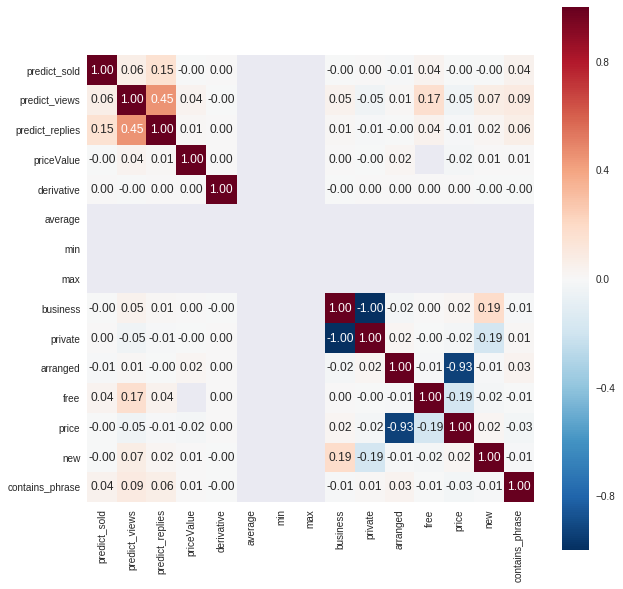

In [111]:
plt.figure(figsize=(10,10))
sns.heatmap(corrmat, square=True, annot=True, fmt ='.2f')

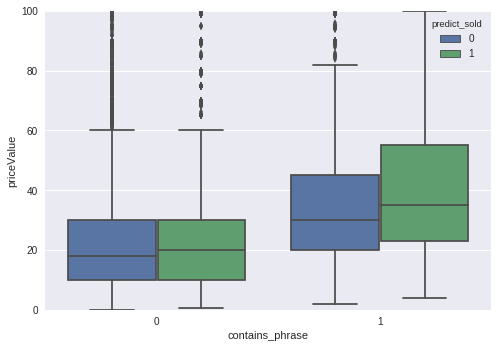

In [107]:
plt.ylim(0,100)
sns.boxplot(x="contains_phrase", 
            y="priceValue", 
            hue="predict_sold", 
            data=cat_230_df)

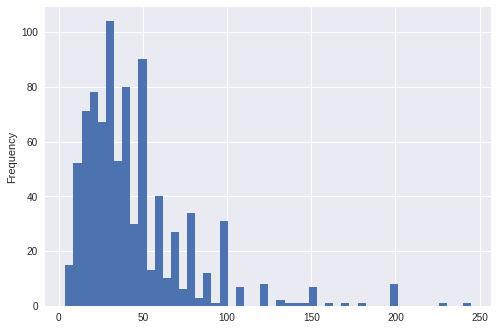

In [125]:
cat_230_df[(cat_230_df['predict_sold'] == 1) & 
           (cat_230_df['contains_phrase'] == 1)]['priceValue'].plot.hist(bins=50)

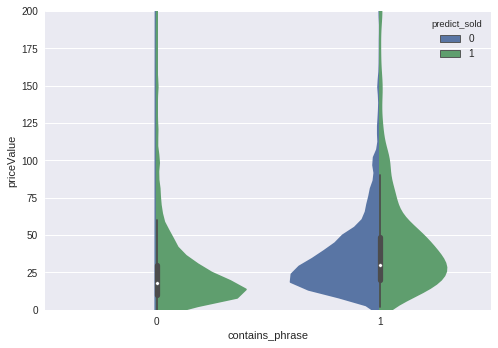

In [134]:
plt.ylim(0,200)
sns.violinplot(x='contains_phrase', y='priceValue', hue='predict_sold', data=cat_230_df, split=True)

In [129]:
cat_230_df_lt1000 = cat_230_df[cat_230_df['priceValue'] < 1000]

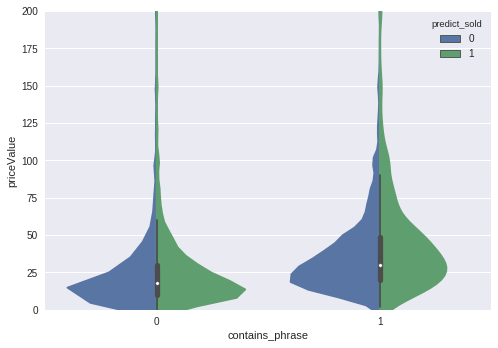

In [130]:
plt.ylim(0,200)
sns.violinplot(x='contains_phrase', y='priceValue', hue='predict_sold', data=cat_230_df_lt1000, split=True)

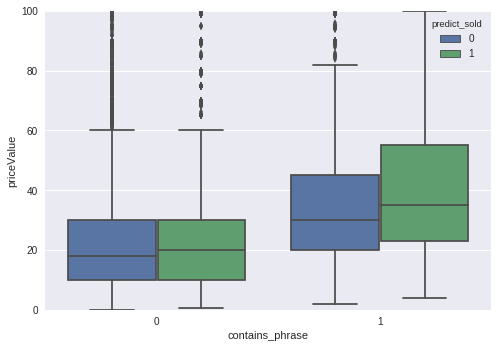

In [131]:
plt.ylim(0,100)
sns.boxplot(x="contains_phrase", 
            y="priceValue", 
            hue="predict_sold", 
            data=cat_230_df_lt1000)

In [132]:
check_sold_percentage_for_category_and_phrase(cat_230_df_lt1000, 230, 'kombinezon', True)

sold amount is  857
not sold amount is 3457


0.19865554010199352

In [135]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report,confusion_matrix
import os

In [147]:
mapper_target_col = {
    'f': 0,
    't': 1
}


_BASE_FEATURES = []
remove_cols = ['business', 'private', 'arranged', 'exchange', 'free', 'price', 'derivative']
def load_train_data(dropna=False):
    test_filename = 'transformed2017_10.csv'
    october = 'transformed2016_11.csv'
    predict_cols = ['predict_sold', 'predict_replies', 'predict_views']
    df = None
    first = True
    for file in os.listdir(DATA_PATH):
        print(file)
        if first and (file != test_filename and file != october):
            df = pd.read_csv(DATA_PATH + file)
            df.drop(['description'], 1)
            first = False
        elif file != test_filename and file != october:
            df = df.append(pd.read_csv(DATA_PATH + file).drop(['description'], 1))
            print(df.columns)
    print(len(df))
    if dropna:
        df = df.dropna()
    df_X = df.drop(['id', 'used'] + predict_cols + remove_cols, 1)
    df_Y = df['predict_sold']
    df_Y = df_Y.map(mapper_target_col)
    return df_X, df_Y

def load_test_data():
    test_filename = 'transformed2017_10.csv'
    df = pd.read_csv(DATA_PATH + 'transformed2017_10.csv')
    return df.drop(['used'] + remove_cols, 1)

In [148]:
X = load_train_data(True)

transformed2017_10.csv
transformed2017_07.csv
transformed2017_05.csv
Index(['arranged', 'average', 'business', 'category_id', 'derivative',
       'description', 'exchange', 'free', 'id', 'max', 'min', 'new',
       'paidads_id_index', 'paidads_valid_to', 'photo_sizes',
       'predict_replies', 'predict_sold', 'predict_views', 'price',
       'priceValue', 'private', 'title', 'used'],
      dtype='object')
transformed2017_03.csv
Index(['arranged', 'average', 'business', 'category_id', 'derivative',
       'description', 'exchange', 'free', 'id', 'max', 'min', 'new',
       'paidads_id_index', 'paidads_valid_to', 'photo_sizes',
       'predict_replies', 'predict_sold', 'predict_views', 'price',
       'priceValue', 'private', 'title', 'used'],
      dtype='object')
transformed2017_08.csv
Index(['arranged', 'average', 'business', 'category_id', 'derivative',
       'description', 'exchange', 'free', 'id', 'max', 'min', 'new',
       'paidads_id_index', 'paidads_valid_to', 'photo_sizes',

In [151]:
X[1].columns

AttributeError: 'Series' object has no attribute 'columns'